In [17]:
#Code 1: This code deals with unsupervised learning, and includes the code for K-means Clustering, Hierarchical Clustering and Spectral Clustering

import warnings;warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

In [18]:
#import diamond dataset
diamond_data = pd.read_csv('/Users/saiveephatak/Desktop/OPSM322/Individual project/diamond dataset categorical.csv')
diamond_data_temp = diamond_data.copy()
diamond_data.dtypes

srno         int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

/Users/saiveephatak/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/saiveephatak/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/saiveephatak/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


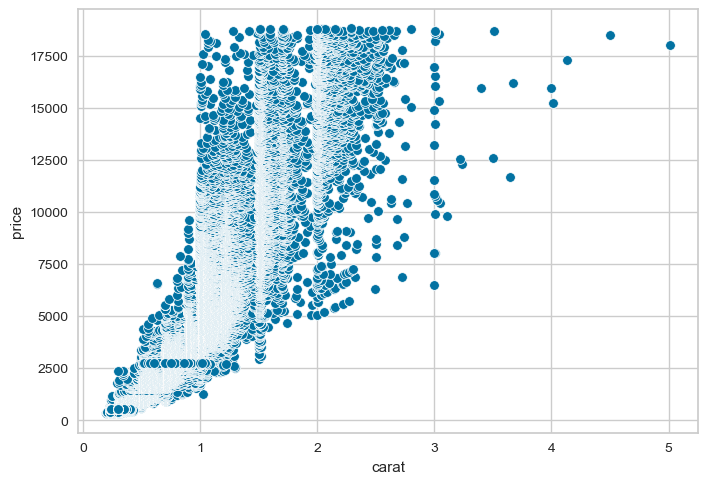

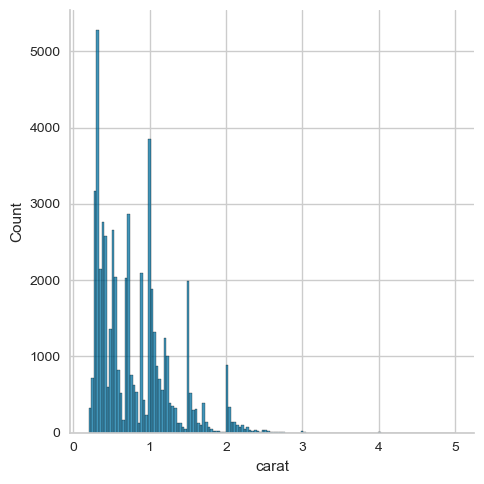

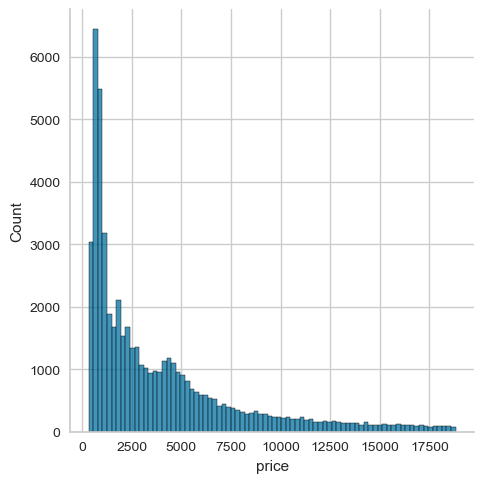

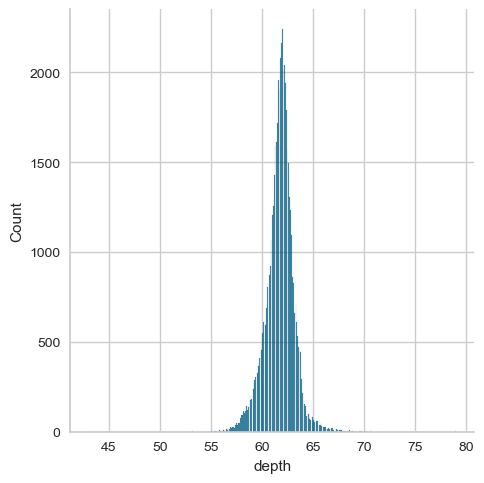

In [19]:
#Basic EDA
sns.scatterplot(x='carat', y='price', data = diamond_data)
sns.displot(x = 'carat', data = diamond_data)
sns.displot(x = 'price', data = diamond_data)
sns.displot(x = 'depth', data = diamond_data)


In [46]:
#Here, there is a clear correlation between the price and the carat of the diamond. Generally, higher the carat, higher is the price for the diamond.
#The price and carat however, are skewed to the left and do not necessarily follow normal distribution. 
#The 'table' which is the percentage of height, width, and depth however, does follow a normal distribution

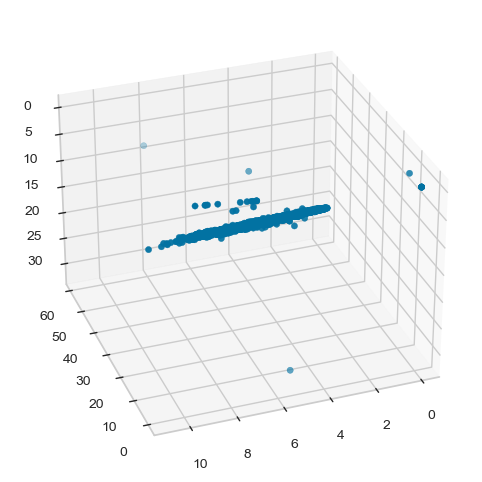

In [20]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
ax.scatter(
    xs='x',
    ys='y',
    zs='z',
    data=diamond_data,
)

In [21]:
#remove the dependant variable which is the cut that we will be clustering
diamond_data.pop('cut')
diamond_data.pop('srno')
diamond_data.head()
diamond_names = diamond_data.columns
diamond_data_dummy = []

In [22]:
#convert clarity and colour to dummy variables
diamond_data_dummy = pd.get_dummies(diamond_data, columns=['clarity', 'color'], drop_first=True).astype(int)
diamond_data_dummy.info()
#remove all the other variables from this dataframe since I have used astype int in the previous lines of code.
diamond_data_dummy.pop('carat')
diamond_data_dummy.pop('depth')
diamond_data_dummy.pop('table')
diamond_data_dummy.pop('price')
diamond_data_dummy.pop('x')
diamond_data_dummy.pop('y')
diamond_data_dummy.pop('z')
diamond_data_dummy.info()
#remove the colour and clarity columns from the diamond_data dataset, and concatenate the diamond_dummy dataset with that to create one full dataset
diamond_data.pop('clarity')
diamond_data.pop('color')
#before we concatenate the dataset, we will normalise the carat, depth, table, price, length, depth and height. According to my research, normalisation does not assume a gaussian distribution. In this case, many of the features are not normally distributed, exhibiting skewness.
norm_scaler = MinMaxScaler()
diamond_normalised = pd.DataFrame(norm_scaler.fit_transform(diamond_data))
#ensure that the column names are added to the normalised dataset
diamond_normalised.rename(columns=dict(zip(diamond_normalised.columns, diamond_data.columns)), inplace=True)

diamond_final = pd.concat([diamond_normalised, diamond_data_dummy], axis=1)
diamond_final.columns = diamond_final.columns.astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   carat         53940 non-null  int64
 1   depth         53940 non-null  int64
 2   table         53940 non-null  int64
 3   price         53940 non-null  int64
 4   x             53940 non-null  int64
 5   y             53940 non-null  int64
 6   z             53940 non-null  int64
 7   clarity_IF    53940 non-null  int64
 8   clarity_SI1   53940 non-null  int64
 9   clarity_SI2   53940 non-null  int64
 10  clarity_VS1   53940 non-null  int64
 11  clarity_VS2   53940 non-null  int64
 12  clarity_VVS1  53940 non-null  int64
 13  clarity_VVS2  53940 non-null  int64
 14  color_E       53940 non-null  int64
 15  color_F       53940 non-null  int64
 16  color_G       53940 non-null  int64
 17  color_H       53940 non-null  int64
 18  color_I       53940 non-null  int64
 19  color_J       53940 non-n

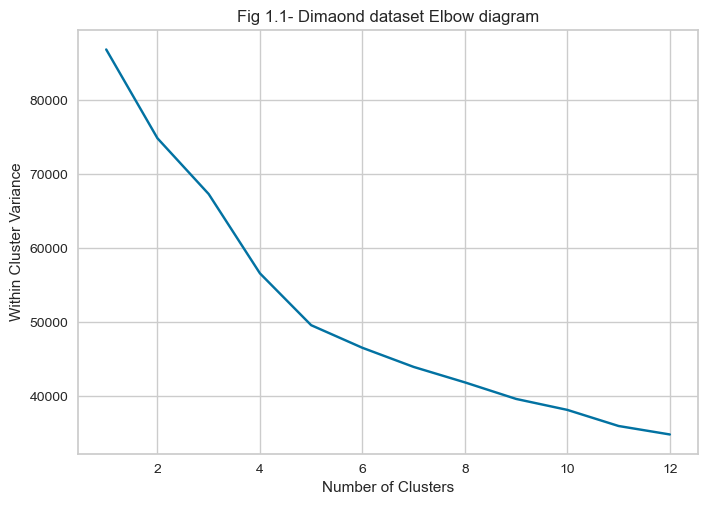

In [23]:
#Create elbow diagram for clustering
max_clust = 12
num_clust = np.arange(1,max_clust+1,1)
wss = np.zeros(max_clust)
for i in range(max_clust):
    cnum = num_clust[i]
    kmeans = KMeans(init="random", n_clusters=cnum, n_init=10, random_state=0).fit(diamond_final)
    wss[i] = kmeans.inertia_

fig = plt.figure()
plt.title("Fig 1.1- Dimaond dataset Elbow diagram")
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Variance")
plt.plot(num_clust, wss)

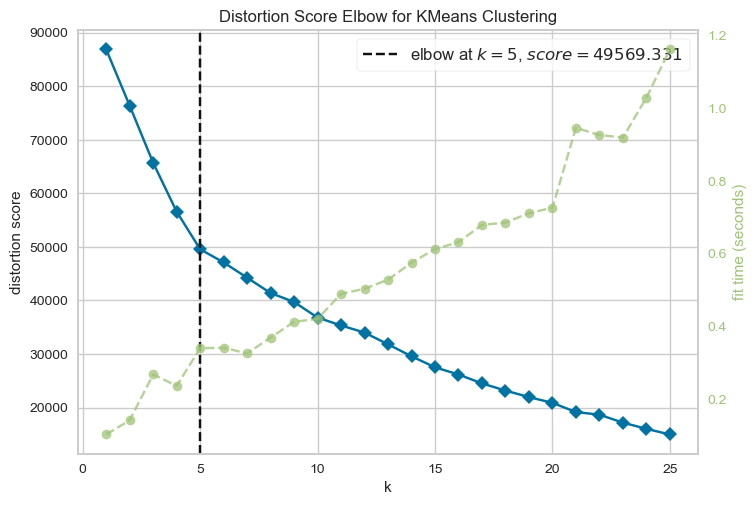

In [24]:
# KElbowVisualizer to further clarify elbow diagram and find out inflection point:
model = KMeans(random_state=0, init='k-means++', n_init=10)
visulizer = KElbowVisualizer(model, k=(1, 26))
visulizer.fit(diamond_final)
visulizer.poof()
plt.show()

In [ ]:
#here, the inflection point on the basis of the KElbow visualiser is 5. Along with that, the normal elbow plot too indicates that the inflection point is at 5 clusters, after which the WCSS starts linearly decreasing.
#K means will be run with 5 clusters on the following dataset

In [25]:
cno1 = 5
cno_arr1 = np.ones((cno1))
kmeans = KMeans(init="random", n_clusters=cno1, n_init=10, random_state=23).fit(diamond_final)
l_lab1 = kmeans.labels_
centroids = kmeans.cluster_centers_
wcss = kmeans.inertia_
print(wcss)


49569.33088269005


In [26]:
#WCSS for normalised 5 clusters is 49569.33, which is significantly lower than un-normalised WCSS for 4 clusters (57125590025.26897)
#here, normalisation seems to play an important role in improving the quality of the clusters. 

Silhouette score = 0.3180608250852328


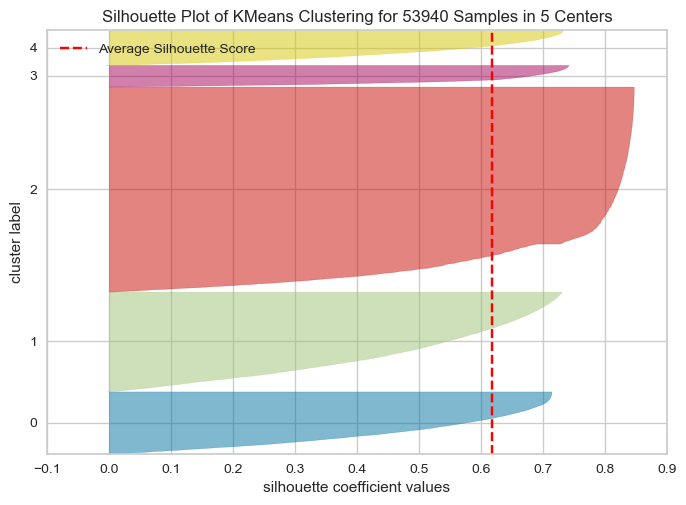

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 53940 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
#calculating the silhouette score
score = silhouette_score(diamond_final, l_lab1, metric='euclidean')
print("Silhouette score = {}".format(score))
model = KMeans(init="random", n_clusters=cno1, n_init=10)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(diamond_data)
visualizer.show()

In [28]:
#The silhouette score for 5 clusters is 0.318.
#in this case, six clusters gave a lower WCSS of 47012.79. 
#However, it is important to note that the silhouette score also decreased to 0.307. The Kmeans model with 5 clusters is the best one to run in this case, giving the highest silhouette score.


In [29]:
#Cluster profiling 
diamond_data_temp['cluster_id'] = l_lab1
q_label =  list(range(1, 21))

<BarContainer object of 20 artists>

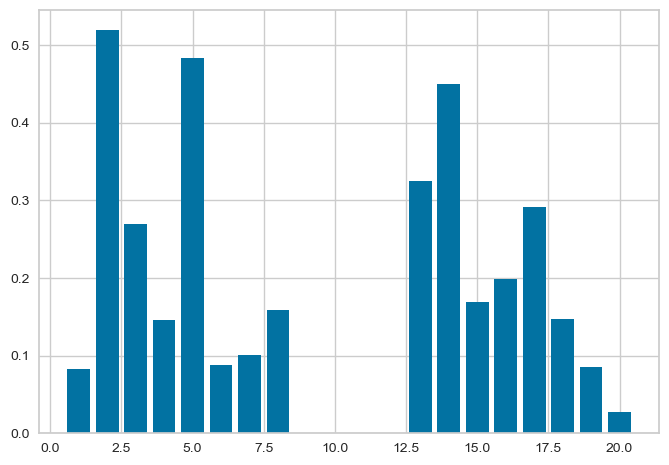

In [30]:
c0_vals = centroids[0].tolist()
plt.bar(q_label, c0_vals)

In [54]:
# For cluster no. 1, the table, which is the width of top of diamond relative to widest point, plays an important role in identifying the cluster. Therefore, the width is also of particular importance in this cluster. Here, the VVS1 and VVS2 clarities are also the key factors of the diamonds in this cluster. It seems that the width and the depth have an impact on the price of the diamond, with the price of this cluster being one of the highest. The colour for the dataset is also an important factor, especially colour type G.


<BarContainer object of 20 artists>

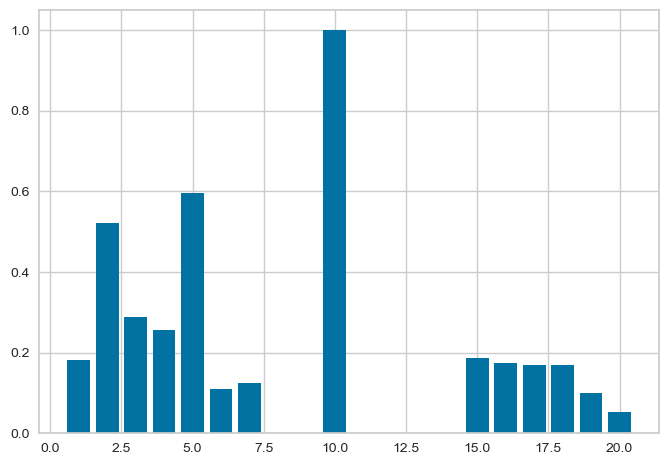

In [31]:
c1_vals = centroids[1].tolist()
plt.bar(q_label, c1_vals)

In [53]:
#In the second cluster, the clarity S12 seems to be the most important factor on which the diamonds are clustered(bar 10). The price here is lower, considering that the depth is lower than the first cluster. However, the clarity of this cluster makes up a bit for the price where the depth compromises it.


<BarContainer object of 20 artists>

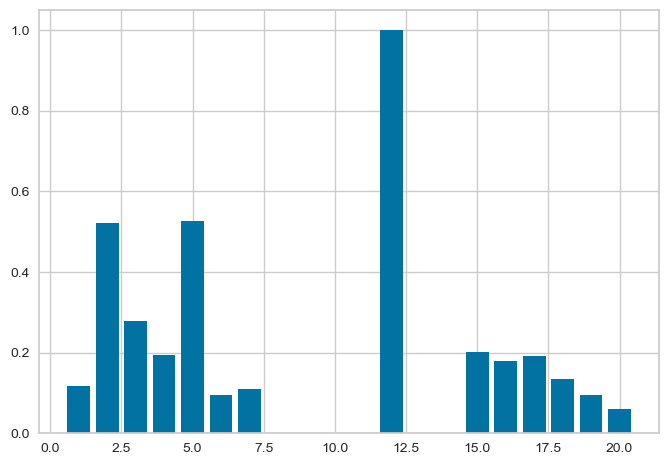

In [32]:
c2_vals = centroids[2].tolist()
plt.bar(q_label, c2_vals)

In [52]:
#In cluster 3, Clarity VS2 is the deciding factors for the clustering of the diamonds. In this case, the clarity is lower than that of cluster 2, and this reflects in the average price(bar 4). Here, from bar 15 onwards depicts the colour of the diamond, and all of them seem to be about the same.


<BarContainer object of 20 artists>

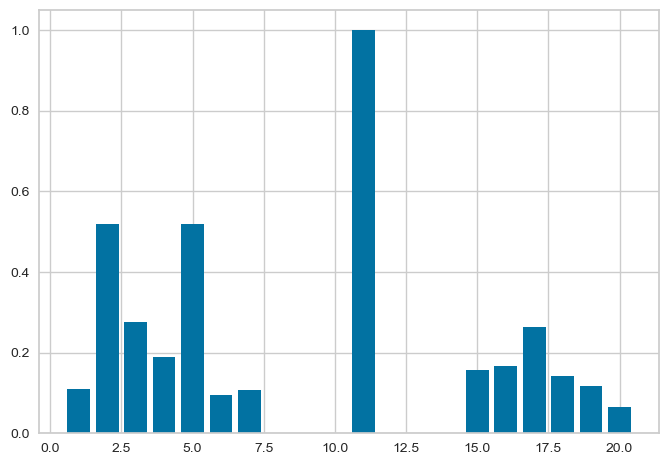

In [33]:
c3_vals = centroids[3].tolist()
plt.bar(q_label, c3_vals)

In [50]:
#In cluster 4, Clarity type VS1 is the deciding factor of the type of diamonds in the cluster. The price ranges similar to that of the third cluster, which makes sense considering that both the clarities are similar to each other.


<BarContainer object of 20 artists>

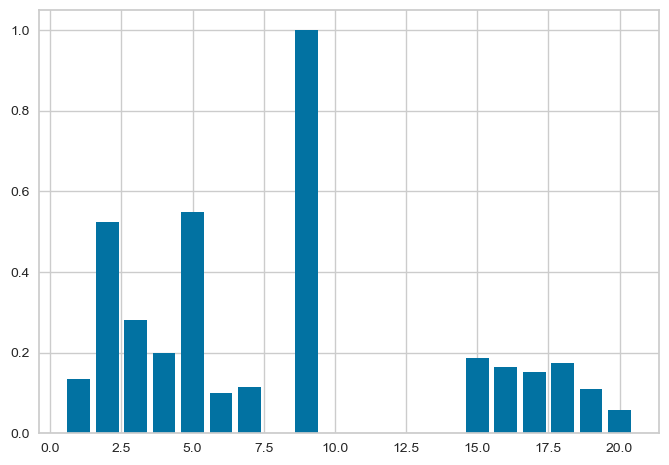

In [34]:
c4_vals = centroids[4].tolist()
plt.bar(q_label, c4_vals)

In [49]:
#The fifth cluster has the clarity S1I as the deciding factor of the diamonds in the cluster. The price again, ranges around that of cluster 3, which makes sense considering that the SI1 clarity is the second best on the rating scale.

In [48]:
#Final comments on profiling
#here, clusters 2, 3, 4 and 5 are ones that are highly dependent on the clarity of the diamonds for clustering. Cluster No. 1 seems to be the cluster that has the absolute highest and absolute lowest clarities. This also makes sense since clarity follows normal distribution, which means that the highest and lowest clarities have some of the lowest number of diamonds in the them. This results in them being clustered in once cluster, since I am forcing just 5 clusters for this dataset.


In [35]:
#since my dataset is approx 50,000 rows, running hierarchical clustering and spectral clustering on it is not something my laptop can handle. 
#Therefore, I will be taking a random sample of 5000 (10% of my dataset) datapoints, and running hierarchical and spectral clustering on them to get a general idea of how both algorithms react with the dataset.
diamond_random_hier = diamond_final.sample(n=5000, random_state=42)
diamond_random_spec = diamond_final.sample(n=5000, random_state=37)

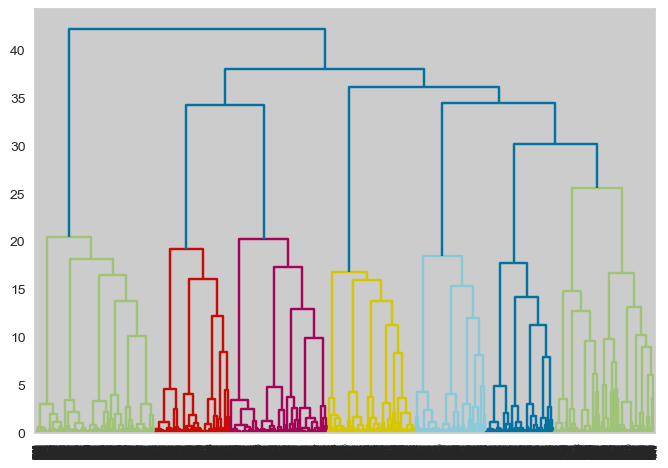

In [36]:
#Hierarchical Clustering
#Plotting the dendrogram
linkage_data = linkage(diamond_random_hier, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

In [37]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(diamond_random_hier)
print(labels)

[0 0 0 ... 0 2 1]


In [38]:
#cutting of tree and calculating most optimal silhouette score
h_cluster_id = cut_tree(linkage_data, n_clusters=6).reshape(-1, )
score = silhouette_score(diamond_random_hier, labels, metric='euclidean')
print("Silhouette score = {}".format(score))

Silhouette score = 0.2556350812672532


In [55]:
#silhouette score for 5 clusters using ward linkage= 0.2298
#silhouette score for 6 clusters using ward linkage= 0.2556
#silhouette score for 5 clusters using average linkage= 0.2057
#silhouette score for 5 clusters using single linkage = 0.1922
#silhouette score for 5 clusters using complete linkage = 0.1220

#Here, 6 clusters using ward linkage provides me with the highest score, which is 0.2556.

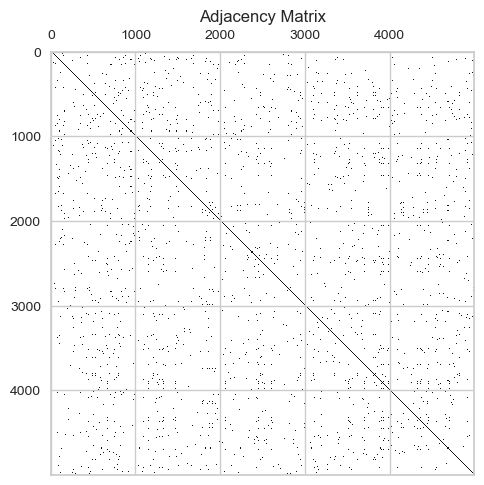

In [40]:
#Spectral Clustering
#Carry out eigen decomposition
distmat = pairwise_distances(diamond_random_spec)
A = (distmat < 0.15).astype(int)
plt.spy(A)
plt.title('Adjacency Matrix')
plt.show()
D = np.diag(np.sum(A, axis=1))
L = D - A
lambd, v = np.linalg.eig(L)
idx = lambd.argsort()
v = v[:, idx]

In [43]:
K = 6
v = v[:, 0:K].real
kmeans = KMeans(n_clusters=K).fit(v)
idx = kmeans.labels_
diamond_random_spec['cluster_id'] = idx

In [44]:
#calculating silhouette score
cluster_labels = diamond_random_spec['cluster_id']
silhouette_avg = silhouette_score(v, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.2681164554328403


In [45]:
#silhouette score with 5 clusters: 0.2415
#silhouette score with 6 clusters: 0.2681
#silhouette score with 7 clusters: 0.2375
#here, you can clearly see that 6 clusters provides the best cluster score. 

In [56]:
#For K-means, 5 clusters provides the most optimal solution, while for hierarchical and spectral clustering, 6 seems to be the most optimal cluster size. The silhouette score for K-means clustering is also the highest, at 0.31 However, considering that we are using only 10% of the data for spectral and hierarchical, we also have to be aware of the generalisability of both these models. In this case, I would go with the K-means model, since it seems to be able to most robustly capture the clustering of the data.